In [1]:
## Using a custom weight matrix with CUBA example from Brian2 docs

location = '/home/pshah/Documents/code/'
import sys; sys.path.append('%sutils_praj' % location)
sys.path.append('%sNeuronalModelling/' % location)

import random
import numpy as np
import matplotlib.pyplot as plt


# recurrent layer
Nn = 4000  # number of neurons in the recurrent layer
W = np.zeros([Nn, Nn])  # matrix of recurrent connection weights, should be a Nn x Nn size array
# W = np.diag(np.ones(Nn)) # -- self connections

def resetw(W=W):
    W = np.zeros([W.shape[0], W.shape[1]])
    return W

# modifying recurrent connection weights as you want to for the network



### 2.2) Trying Low rank connectivity for correlation structure (using the main Renart model)

also trying out new code for correlation measurement and firing rate plotting

2021-10-06

In [2]:
# Brian2 network

from brian2 import *
from brian2_recurrentnet_seizures.brian2_utils import *

In [3]:
def setrandomvector(min, max, N):
    return (max - min) * np.random.random(N) + min

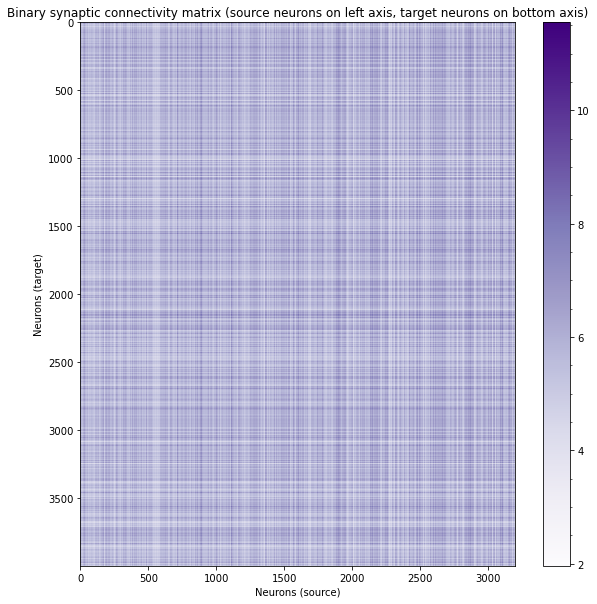

In [4]:
# using the excitatory synaptic weight for the CUBA model
w_e = 2.4  # excitatory synaptic weight

Nn = 4000

Ne = int(Nn * 0.8) ## exc neurons will be only source neurons
Ni = int(Nn * 0.2)  ## inh neurons that will be targeted by exc neurons

v1 = setrandomvector(w_e - 1, w_e + 1, Ne)
v2 = setrandomvector(w_e - 1, w_e + 1, Ne+Ni)

mtx = np.outer(v1, v2) # structured connectivity matrix

plot_connectivity_matrix(conn_matrix=mtx.T, color_lim=[np.min(mtx), np.max(mtx)], colorbar=True)

In [5]:
mtx.shape

(3200, 4000)

In [6]:
weight_matrix = mtx
Ntotal=Nn
stim_external = False
runtime = 5*second
input_rate = 0.05
neurons_to_stim = np.arange(20,400)
start_scope()

#####

# setup for network:
# Parameters
Cm = 0.25 * nfarad
gL = 16.7 * nsiemens

# Ntotal = 5000  # total number of neurons (80/20 split for E and I neurons defined below in the network build function)
Nx = int(0.8 * Ntotal)  # number of X (external population) neurons

tau = 15 * ms
Vl = -75 * mV  # resting potential
V_t = -50 * mV  # threshold
V_refrac = -60 * mV  # refractory voltage

# Time constants
tau_d = 5 * ms  # synaptic decay timeconstant
tau_g = 25 * ms  # timescale of the inh. exhaust mechanism need to find better justification for the proper timescale of this for the actual simulation

# Reversal potentials
Ee = 0 * mV
V_rev_X = 0 * mV
Ei = -80 * mV
# w_e = 2.4 * nsiemens  # excitatory synaptic weight
w_i = 40 * nsiemens  # inhibitory synaptic weight
w_x = 5.4 * nsiemens  # external input synaptic weight

gi_t = 16000 * nsiemens  # threshold value after which synaptic inh. strength starts to decrease - raise to like 10000 to inactivate
factor = 1 * nsiemens  # factor needed for the model eqs for the exhaust inh part

# runtime = 5 * second
dt = 0.1 * ms

# # EXTERNAL STIMULUS (I KNOW THAT THE ORDER OF THIS IS REALLY WEIRD BUT THIS SECTION AND THE MODEL EQS CANNOT BE ADDED TO THE NETWORK BUILD FUNCTION DEFINITION SINCE IT KICKS UP ERRORS IN BRIAN
# define external stimulus as a TimedArray of time dependent values
stim_onset = 2.000 * second
stim_off = 3.999 * second
stim = np.empty([int(runtime / dt), Ntotal])
# stimulus = TimedArray(stim * amp, dt=0.1 * ms)  # constant current input into the specified  cells at the specified onset and offset times
if stim_external:
    print('!STIMULATION ACTIVE!')
    print('|- Neurons specified for stim: ', neurons_to_stim[0], ' to ', neurons_to_stim[-1])
    print('|- stim length: ', stim_off - stim_onset)
    stim[int(stim_onset / dt):int(stim_off / dt), neurons_to_stim] = 5
stimulus = TimedArray(stim * amp,
                      dt=0.1 * ms)  # constant current input into the specified  cells at the specified onset and offset times

# The model
eqs = Equations('''
dV/dt = 1/Cm * (stimulus(t,i) + gL*(Vl - V) + ge*(Ee-V) + gi*(Ei-V)) : volt (unless refractory)
dge/dt = -ge/tau_d : siemens
dgi/dt = -gi/tau_d : siemens
''')

#####

# start_scope()

Pe = NeuronGroup(Ne, model=eqs, threshold='V > V_t', refractory=2*ms, reset= 'V = V_refrac',
                    method='euler', dt=0.1*ms)
Pi = NeuronGroup(Ni, model=eqs, threshold='V > V_t', refractory=2*ms, reset= 'V = V_refrac',
                    method='euler', dt=0.1*ms)

##### make synaptic connections and specify the synaptic model
# using custom synaptic connectivity matrix from above
W = weight_matrix  # custom connectivity matrix

Cee = Synapses(Pe, Pe, 'w_e: siemens', on_pre='ge += w_e')
Cee.connect()
Cee.w_e[:] = W[:, :Ne].flatten() * nsiemens

Cei = Synapses(Pe, Pi, 'w_e: siemens', on_pre='ge += w_e')
Cei.connect()
Cei.w_e[:] = W[:, Ne:].flatten() * nsiemens

Cie = Synapses(Pi, Pe, on_pre='gi += w_i')
Cie.connect('i>=Ni', p=0.2)
Cii = Synapses(Pi, Pi, on_pre='gi += w_i')
Cii.connect('i>=Ni', p=0.2)


# adding a synaptic delay to the pre-synaptic pathways
Cei.delay = '1*ms + randn()/2 * ms'
Cee.delay = '1*ms + randn()/2 * ms'
Cie.delay = '0.5*ms + randn()/2 * ms'
Cii.delay = '0.5*ms + randn()/2 * ms'
#

# BACKGROUND Poisson input
G = PoissonGroup(Nx, rates=input_rate * Hz, dt=0.1 * ms)
CXe = Synapses(G, Pe, on_pre='ge+=w_x')
CXi = Synapses(G, Pi, on_pre='ge+=w_x')
CXe.connect(p=0.2)  # Excitatory external drive connectivity
CXi.connect(p=0.2)  # Excitatory external drive connectivity

# Initialization
Pe.V = 'Vl + rand() * (V_t - Vl)'  # add some randomness to the initial membrane potential
Pe.ge = 0
Pe.gi = 0
# Pe.z = 1.

Pi.V = 'Vl + rand() * (V_t - Vl)'  # add some randomness to the initial membrane potential
Pi.ge = 0
Pi.gi = 0
# Pi.z = 1.


# Setup a few monitors
trace = StateMonitor(Pe, 'V', record=[1, 10, 400, 600])
s_mon_e = SpikeMonitor(Pe)

# trace = StateMonitor(G, 'V', record=record_id)
# trace_ge = StateMonitor(G, 'ge', record=record_id)
# trace_gi = StateMonitor(G, 'gi', record=record_id)
# s_mon = SpikeMonitor(G)
# s_mon_p = SpikeMonitor(P)

# # these are for tracking the Inh. exhaust stuff
# trace_z = StateMonitor(Pe, 'z', record=record_id)
# trace_gi = StateMonitor(Pe, 'gi', record=record_id)
# trace_gi_diff = StateMonitor(Pe, 'gi_diff', record=record_id)

net = Network(collect())

######
net.run(runtime, report='text')



WARNING    "dt" is an internal variable of group "poissongroup", but also exists in the run namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "w_e" is an internal variable of group "synapses_1", but also exists in the run namespace with the value 2.4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "w_e" is an internal variable of group "synapses", but also exists in the run namespace with the value 2.4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
3.2931 s (65%) simulated in 10s, estimated 5s remaining.
3.3322 s (66%) simulated in 20s, estimated 10s remaining.
3.3712 s (67%) simulated in 30s, estimated 15s remaining.
3.4107 s (68%) simulated in 40s, estimated 19s remaining.
3.4496 s (68%) simulated in 50s, estimated 23s remaining.
3.4891 s (69%) simulated in 1m 0s, estimated 26s remaining.
3.5283 s (70%) simulated in 1m 10s, estimated 29s remaining.
3.5672 s (71%) simulated in 1m 20s, estimated 32s remaining.
3.6066 s (72%) simulated in 1m 30s, estimated 35s remaining.
3.6454 s (72%) simulated in 1m 40s, estimated 37s remaining.
3.685 s (73%) simulated in 1m 50s, estimated 39s remaining.
3.7242 s (74%) simulated in 2m 0s, estimated 41s remaining.
3.7633 s (75%) simulated in 2m 10s, estimated 43s remaining.
3.8028 s (76%) simulated in 2m 20s, estimated 44s remaining.
3.8416 s (76%) simulated in 2m 30s, estimated 45s remaining.
3.8812 s (77%) simulated in 2m 40s, estimated 46s r

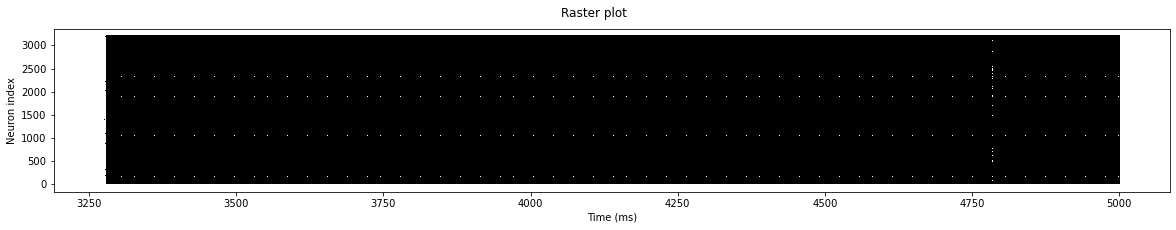

In [7]:
plot_raster(spike_monitor = s_mon_e)

In [8]:
spike_monitor_trains = [(array/dt).astype(int64) for array in list(s_mon_e.spike_trains().values())]

spike_monitor_trains_e = [spike_monitor_trains[i] for i in range(len(spike_monitor_trains)) if i in range(Ne)]


In [9]:
binsize = 0.10 # secs
spike_array, spike_raster_binned, spike_counts_binned = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=Ne,
                                                                            rectime=runtime/second, rec_offset=0, dt=dt/ms/1000., binsize=binsize)


collecting binned spikes rasters... 100.0 ms bin size


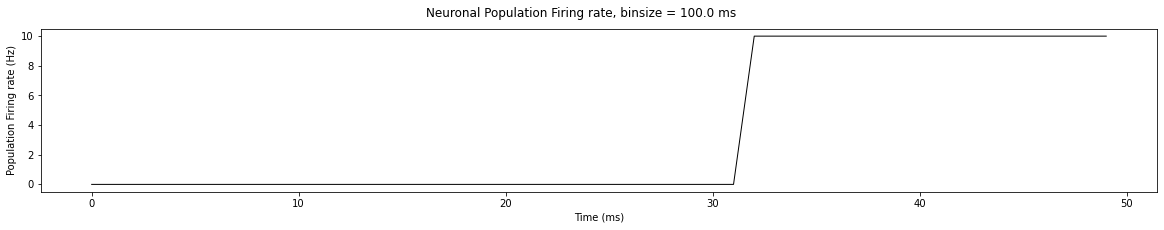

In [10]:
plot_firing_rate(spike_raster_binned, rec_start=None, rec_stop=None, binsize_sec=binsize)

Avg. corr coef value:  0.9999999999999998


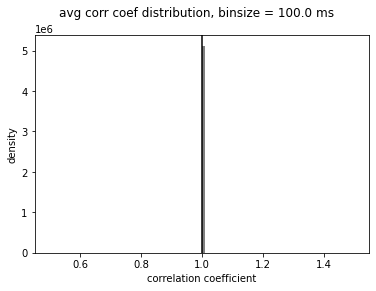

In [11]:
avg_corr = corr_coef(spike_raster_binned, binsize=binsize)


### 2.1) Trying Low rank connectivity for correlation structure (using the CUBA example model)

also trying out new code for correlation measurement and firing rate plotting

2021-10-06

In [2]:
# Brian2 network

from brian2 import *
from brian2_recurrentnet_seizures.brian2_utils import *

In [3]:
def setrandomvector(min, max, N):
    return (max - min) * np.random.random(N) + min

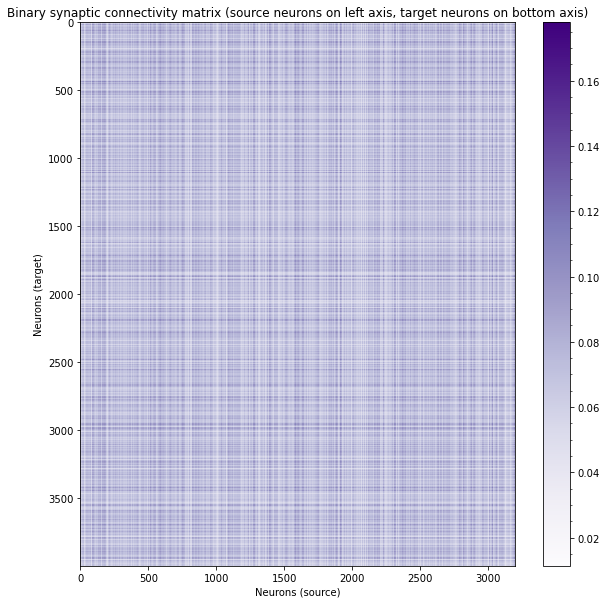

In [139]:
# using the excitatory synaptic weight for the CUBA model
w_e = (60*0.27/10)  # mV; excitatory synaptic weight (voltage)  (this is equal to [E_exc = 0mV - V_rest = -60mV] * g_exc = 0.27nS

Nn = 4000

Ne = int(Nn * 0.8) ## exc neurons will be only source neurons
Ni = int(Nn * 0.2)  ## inh neurons that will be targeted by exc neurons

v1 = setrandomvector(w_e - 1, w_e + 1, Ne)
v2 = setrandomvector(w_e - 1, w_e + 1, Ne+Ni)

mtx = np.outer(v1, v2) / (Nn/10)  # structured connectivity matrix

mtx_R = np.random.uniform(w_e - 1, w_e + 1, (Ne, Ne+Ni)) / (Nn/10) # random connectivity matrix

j = 10
g = 1

mtx_total = (j*mtx + g*mtx_R)

plot_connectivity_matrix(conn_matrix=mtx_total.T, color_lim=[np.min(mtx_total), np.max(mtx_total)], colorbar=True)

In [140]:
mtx.shape

(3200, 4000)

In [141]:
#%% original CUBA model from Brian2
start_scope()

runtime = 3 * second
dt = 0.1*ms

taum = 20*ms
taue = 5*ms
taui = 10*ms
Vt = -50*mV
Vr = -60*mV
El = -49*mV  # resting potential / leak reversal potential

eqs = """
dv/dt  = (ge+gi-(v-El))/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
"""

# P = NeuronGroup(Ne + Ni, eqs, threshold='v>Vt', reset='v = Vr', refractory=5*ms,
#                 method='exact')

Pe = NeuronGroup(Ne, eqs, threshold='v>Vt', reset='v = Vr', refractory=5*ms,
                method='exact')
Pi = NeuronGroup(Ni, eqs, threshold='v>Vt', reset='v = Vr', refractory=5*ms,
                method='exact')

# initialization
Pe.v = "Vr + rand() * (Vt - Vr)"
Pi.v = "Vr + rand() * (Vt - Vr)"
# P.v = 'Vr'
Pe.ge = 0*mV
Pe.gi = 0*mV
Pi.ge = 0*mV
Pi.gi = 0*mV

# make synaptic connections and specify the synaptic model
# w_e = (60*0.27/10)*mV # excitatory synaptic weight (voltage)  (this is equal to [E_exc = 0mV - V_rest = -60mV] * g_exc = 0.27nS
w_i = (-20*4.5/10)*mV # inhibitory synaptic weight


# using custom synaptic connectivity matrix from above
W = mtx  # custom connectivity matrix

Cee = Synapses(Pe, Pe, 'w_e: volt', on_pre='ge += w_e')
Cee.connect()
Cee.w_e[:] = W[:, :Ne].flatten()*mV

Cei = Synapses(Pe, Pi, 'w_e: volt', on_pre='ge += w_e')
Cei.connect()
Cei.w_e[:] = W[:, Ne:].flatten()*mV



In [142]:
# for i in range(Ne):
#     msg = 'connecting neuron %s' % i
#     print(msg, end='\r')
#     for j in range(Ne + Ni):
#         Ce.w_e[i, j] = W[i,j]*mV


In [ ]:
Cie = Synapses(Pi, Pe, on_pre='gi += w_i')
Cie.connect('i>=Ni', p=0.5)

Cii = Synapses(Pi, Pi, on_pre='gi += w_i')
Cii.connect('i>=Ni', p=0.5)

trace = StateMonitor(Pe, 'v', record=[1, 10, 400, 600])
s_mon = SpikeMonitor(Pe)

run(runtime, report='text')

plot_raster(spike_monitor = s_mon)

Starting simulation at t=0. s for a duration of 3. s


In [ ]:
spike_monitor_trains = [(array/dt).astype(int64) for array in list(s_mon.spike_trains().values())]

spike_monitor_trains_e = [spike_monitor_trains[i] for i in range(len(spike_monitor_trains)) if i in range(Ne)]


In [ ]:
binsize = 0.010 # secs
spike_array, spike_raster_binned, spike_counts_binned = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=Ne,
                                                                            rectime=runtime/second, rec_offset=0, dt=dt/ms/1000., binsize=binsize)


In [ ]:
def plot_firing_rate(spike_raster_binned, rec_start=None, rec_stop=None, binsize_sec=0.01, title= 'Neuronal Population Firing rate'):
    """calculate and plot firing rate across 10ms timebins"""

    firing_rate_binned = np.sum(spike_raster_binned, axis=0)
    firing_rate_binned_norm = firing_rate_binned / binsize_sec / spike_raster_binned.shape[0]
    plt.figure(figsize=[20, 3])
    plt.plot(firing_rate_binned_norm, c='black', linewidth=1)
    plt.xlabel('Time (ms)')
    plt.ylabel('Population Firing rate (Hz)')
    if rec_start and rec_stop:
        plt.xlim(rec_start, rec_stop)
    # title = 'avg firing rate %s' % (np.sum(firing_rate_binned_norm[params['rec_start']/1000/binsize_sec:params['rec_stop']/1000/binsize_sec])/len(firing_rate_binned_norm[params['rec_start']/1000/binsize_sec:params['rec_stop']/1000/binsize_sec]))
    plt.suptitle(title + ', binsize = %s ms' % (binsize_sec * 1000))
    plt.show()


In [ ]:
plot_firing_rate(spike_raster_binned, binsize_sec=binsize)

In [ ]:
avg_corr = corr_coef(spike_raster_binned, binsize=binsize)


In [ ]:
def powerlawfit(data: np.array, subset: list = None, plot_subset: list = None):
    x = range(len(data))[subset[0]:subset[1]]
    y = data[subset[0]:subset[1]]


    # to perform powerlaw fit, first take data into log-log space and then do linear regression in that space
    res = stats.linregress(np.log2(x), np.log2(y))
    print(res)

    x_fit = range(len(data))[10:]
    y_fit = res.intercept + res.slope * np.log2(x_fit)

    fig, ax = plt.subplots(figsize=[6,6])
    ax.plot(np.log2(range(len(data))[plot_subset[0]:plot_subset[1]]), np.log2(data[plot_subset[0]:plot_subset[1]]), label='original data', color='darkblue')
    ax.plot(np.log2(x_fit), y_fit, c = 'darkgreen', label='fitted line')
    ax.legend()
    ax.set_xlabel('PC Dimension')
    ax.set_ylabel('Variance (|eigenvalue|)')
    plt.show()

    return res.slope

In [ ]:
explained_variance_ratio_ = pca_spike_raster(spike_raster_binned)
print("n dims:", len(explained_variance_ratio_))
alpha = powerlawfit(data = explained_variance_ratio_, subset = [10,100], plot_subset = [10, 296])
print('the alpha value is: ', alpha)

### 1) using a spatially localized connectivity matrix

In [2]:
# %% building a spatially localized connectivity matrix
####################################################

W = resetw()

p_e = 0.2  # probability of e-e connections
p_i = 0.2  # probability of Inh. neurons

Ne = random.sample(range(Nn), int(0.8*Nn))
Ni = [x for x in range(Nn) if x not in Ne]
struc_num = Nn

# need to intersperse E and I neurons throughout the whole cell population
for i in range(Nn):
    # select random indexes to setup as connections based on selected probability
    # set E --> all connectivity
    if i in Ne:
        j = [int(target) for target in np.random.normal(i,struc_num, int(p_e*len(W[i]))) if 0 < target < Nn]
        W[i, j] = 1

    # set I --> all connectivity
    elif i in Ni:
        j = [int(target) for target in np.random.normal(i, struc_num, int(p_i * len(W[i]))) if 0 < target < Nn]
        W[i, j] = 1

i, j = W[Ni].nonzero()
sources = [Ni[x] for x in i]
targets = [range(Nn)[x] for x in j]

In [2]:
# Brian2 network

from brian2 import *
from brian2_recurrentnet_seizures.brian2_utils import *

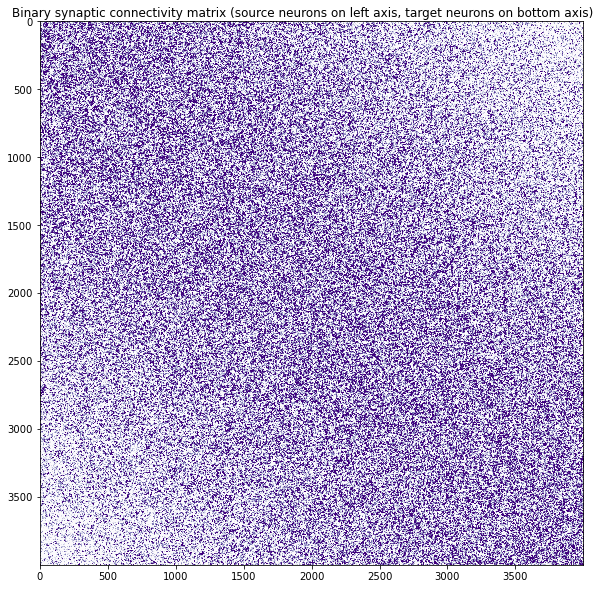

In [4]:
# %% plot connectivity matrix
plot_connectivity_matrix(conn_matrix=W)

Starting simulation at t=0. s for a duration of 3. s
3. s (100%) simulated in 3s


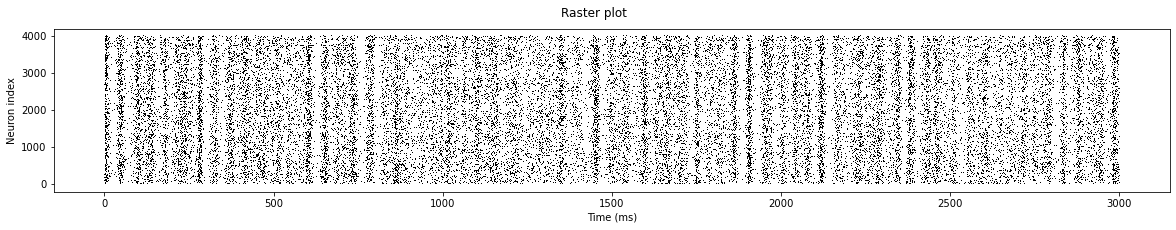

In [5]:
#%% original CUBA model from Brian2
start_scope()

runtime = 3 * second
dt = 0.1*ms

taum = 20*ms
taue = 5*ms
taui = 10*ms
Vt = -50*mV
Vr = -60*mV
El = -49*mV

eqs = """
dv/dt  = (ge+gi-(v-El))/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
"""

P = NeuronGroup(4000, eqs, threshold='v>Vt', reset='v = Vr', refractory=5*ms,
                method='exact')

# initialization
P.v = "Vr + rand() * (Vt - Vr)"
# P.v = 'Vr'
P.ge = 0*mV
P.gi = 0*mV

# make synaptic connections and specify the synaptic model
w_e = (60*0.27/10)*mV # excitatory synaptic weight (voltage)  (this is equal to [E_exc = 0mV - V_rest = -60mV] * g_exc = 0.27nS
w_i = (-20*4.5/10)*mV # inhibitory synaptic weight


# using custom synaptic connectivity matrix from above
Ce = Synapses(P, P, on_pre='ge += w_e')
i, j = W[Ne].nonzero()
sources = [Ne[x] for x in i]
targets = [range(Nn)[x] for x in j]
Ce.connect(i=sources, j=targets)

Ci = Synapses(P, P, on_pre='gi += w_i')
i, j = W[Ni].nonzero()
sources = [Ni[x] for x in i]
targets = [range(Nn)[x] for x in j]
Ci.connect(i=sources, j=targets)


trace = StateMonitor(P, 'v', record=[1, 10, 400, 600])
s_mon = SpikeMonitor(P)

run(runtime, report='text')

plot_raster(spike_monitor = s_mon)

collected binned spikes rasters...


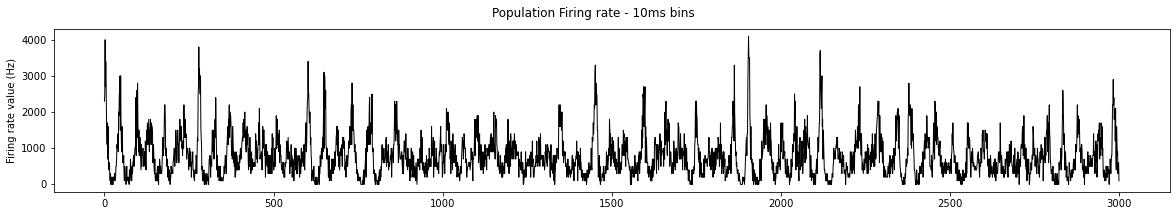

collected binned spikes rasters...


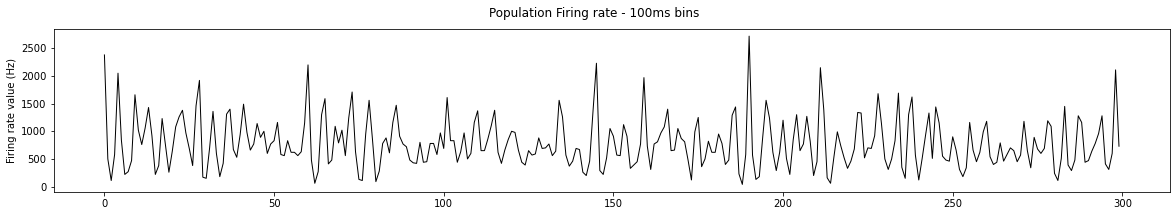

In [6]:
spike_monitor_trains = [(array/dt).astype(int64) for array in list(s_mon.spike_trains().values())]

spike_monitor_trains_e = [spike_monitor_trains[i] for i in range(len(spike_monitor_trains)) if i in Ne]

# create numpy array of spikes:
spike_array, spike_counts_binned, spike_raster_binned = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=len(Ne), runtime=runtime, dt=dt, binsize=10)
plot_firing_rate(spike_raster_binned, binsize_sec=0.01, title='Population Firing rate - 10ms bins')

spike_array, spike_counts_binned, spike_raster_binned = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=len(Ne), runtime=runtime, dt=dt, binsize=100)
plot_firing_rate(spike_raster_binned, binsize_sec=0.1, title='Population Firing rate - 100ms bins')

# spike_array, spike_counts_binned, spike_raster_binned = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=len(Ne), runtime=runtime, dt=dt, binsize=50)
# plot_firing_rate(spike_raster_binned, binsize_sec=0.1, title='Population Firing rate - 50ms bins')



WARNING    /home/pshah/anaconda3/envs/2021/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /home/pshah/anaconda3/envs/2021/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


0.007929873158609149


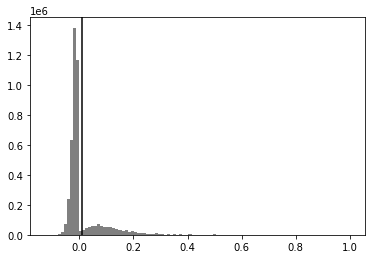

In [7]:
#%% calculate correlation coefficients
corr_mtx = np.corrcoef(spike_raster_binned)
x = corr_mtx[np.triu_indices(corr_mtx.shape[0], k=1)]
# not sure why but there are nan values coming up in the corr_values calculation
# remove nans from corr_values

corr_values = x[~np.isnan(x)]
avg_corr = np.mean(corr_values)
print(np.mean(corr_values))

plt.hist(corr_values, bins=100, color='gray')
plt.axvline(x=avg_corr, color='black')
plt.show()

In [8]:
def powerlawfit(data: np.array, subset: list = None, plot_subset: list = None):
    x = range(len(data))[subset[0]:subset[1]]
    y = data[subset[0]:subset[1]]


    # to perform powerlaw fit, first take data into log-log space and then do linear regression in that space
    res = stats.linregress(np.log2(x), np.log2(y))
    print(res)

    x_fit = range(len(data))[10:]
    y_fit = res.intercept + res.slope * np.log2(x_fit)

    fig, ax = plt.subplots(figsize=[6,6])
    ax.plot(np.log2(range(len(data))[plot_subset[0]:plot_subset[1]]), np.log2(data[plot_subset[0]:plot_subset[1]]), label='original data', color='darkblue')
    ax.plot(np.log2(x_fit), y_fit, c = 'darkgreen', label='fitted line')
    ax.legend()
    ax.set_xlabel('PC Dimension')
    ax.set_ylabel('Variance (|eigenvalue|)')
    plt.show()

    return res.slope

n dims: 300
LinregressResult(slope=-0.36839629130654744, intercept=-5.500443880735858, rvalue=-0.9836534394486836, pvalue=2.5984688371320178e-67, stderr=0.0071891557431831045, intercept_stderr=0.04038886115609865)


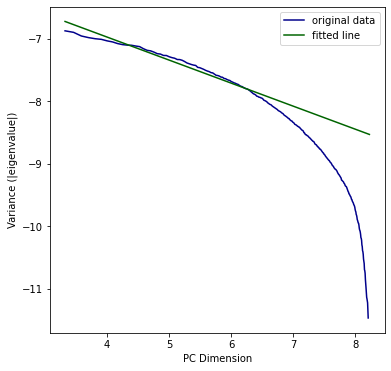

In [9]:
explained_variance_ratio_ = pca_spike_raster(spike_raster_binned)
print("n dims:", len(explained_variance_ratio_))
alpha = powerlawfit(data = explained_variance_ratio_, subset = [10,100], plot_subset = [10, 296])

WARNING    <ipython-input-10-1b1c19dde8cc>:25: RuntimeWarning: divide by zero encountered in log2
  plt.plot(np.log2(x_full), np.log2(data), label='original data', color='steelblue')
 [py.warnings]


LinregressResult(slope=-0.3765806957543428, intercept=5.48852353549418, rvalue=-0.8572821380152339, pvalue=9.270625910961286e-87, stderr=0.013189815473502437, intercept_stderr=0.09199171080917035)


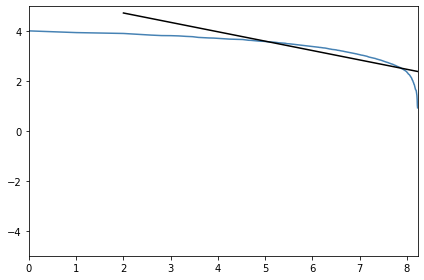

In [10]:
# PCA and powerlaw fit of the eigen decomposition


pca = PCA(n_components=min(spike_raster_binned.shape))
pca.fit(spike_raster_binned)
pca_result = pd.DataFrame(pca.transform(spike_raster_binned))  # , columns=['PCA%i' % i for i in range(275)])
sv = pca.singular_values_
su = (sv / sum(sv))

data = pca.explained_variance_ratio_
data = sv

subset = [2**2,2**9]

# fit and plot variance per PC

x = range(len(data))[subset[0]:subset[1]]
y = data[subset[0]:subset[1]]

# to perform powerlaw fit, first take data into log-log space and then do linear regression in that space
res = stats.linregress(np.log2(x), np.log2(y))
print(res)

x_full = range(len(data))
plt.plot(np.log2(x_full), np.log2(data), label='original data', color='steelblue')
plt.plot(np.log2(x), res.intercept + res.slope * np.log2(x), c = 'black', label='fitted line')
plt.ylim(-5, 5)
plt.margins(x=0)
plt.tight_layout()
plt.show()



In [11]:
print(data[:20])
print(sv[:20])
print(su[:20])

[25.04804938 16.20622203 15.45170257 15.22021904 15.08421925 14.70465057
 14.41370318 14.22037514 14.19181474 14.09175924 13.91138136 13.79490469
 13.51844528 13.39776579 13.31607861 13.26953222 13.1584648  13.08116369
 12.96180044 12.88792279]
[25.04804938 16.20622203 15.45170257 15.22021904 15.08421925 14.70465057
 14.41370318 14.22037514 14.19181474 14.09175924 13.91138136 13.79490469
 13.51844528 13.39776579 13.31607861 13.26953222 13.1584648  13.08116369
 12.96180044 12.88792279]
[0.01024532 0.00662877 0.00632016 0.00622547 0.00616985 0.00601459
 0.00589559 0.00581651 0.00580483 0.0057639  0.00569012 0.00564248
 0.0055294  0.00548004 0.00544663 0.00542759 0.00538216 0.00535054
 0.00530172 0.0052715 ]


In [12]:
x_full

range(0, 300)